In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
torch.cuda.empty_cache()
print(f"Using device: {device}")

Using device: cuda


In [2]:
class QuadcopterEnv:
    def __init__(self):
        # Physical parameters
        self.m = 0.5  # mass in kg
        self.g = 9.81  # gravity
        self.l = 0.25  # arm length in meters
        self.Ixx = 5e-3  # moment of inertia
        self.Iyy = 5e-3
        self.Izz = 1e-2
        self.k = 3e-6   # thrust coefficient
        self.b = 0   # drag coefficient
        self.kd = 0  # drag coefficient
        
        # Inertia matrix
        self.I = np.array([[self.Ixx, 0, 0],
                          [0, self.Iyy, 0],
                          [0, 0, self.Izz]])
        self.I_inv = np.linalg.inv(self.I)
        
    def rotation_matrix(self, angles):
        """Compute rotation matrix from euler angles (phi, theta, psi)"""
        phi, theta, psi = angles
        
        # Individual rotation matrices
        R_x = np.array([[1, 0, 0],
                       [0, np.cos(phi), -np.sin(phi)],
                       [0, np.sin(phi), np.cos(phi)]])
        
        R_y = np.array([[np.cos(theta), 0, np.sin(theta)],
                       [0, 1, 0],
                       [-np.sin(theta), 0, np.cos(theta)]])
        
        R_z = np.array([[np.cos(psi), -np.sin(psi), 0],
                       [np.sin(psi), np.cos(psi), 0],
                       [0, 0, 1]])
        
        return R_z @ R_y @ R_x
    
    def compute_forces_moments(self, state, inputs):
        """Compute forces and moments from motor inputs"""
        # Motor angular velocities (squared)
        w1, w2, w3, w4 = inputs
        
        # Total thrust
        thrust = self.k * sum(inputs)
        
        # Moments
        tau_phi = self.l * self.k * (w1 - w3)
        tau_theta = self.l * self.k * (w2 - w4)
        tau_psi = self.b * (w1 - w2 + w3 - w4)
        
        return thrust, np.array([tau_phi, tau_theta, tau_psi])
    
    def dynamics(self, state, inputs):
        """Compute state derivatives"""
        # Unpack state
        # [x, y, z, x_dot, y_dot, z_dot, phi, theta, psi, phi_dot, theta_dot, psi_dot]
        pos = state[0:3]
        vel = state[3:6]
        angles = state[6:9]
        omega = state[9:12]
        
        # Compute rotation matrix
        R = self.rotation_matrix(angles)
        
        # Compute forces and moments
        thrust, moments = self.compute_forces_moments(state, inputs)
        
        # Linear accelerations
        gravity = np.array([0, 0, -self.g])
        thrust_body = np.array([0, 0, thrust/self.m])
        acc = gravity + R @ thrust_body - self.kd/self.m * vel
        
        # Angular accelerations
        omega_skew = np.array([[0, -omega[2], omega[1]],
                              [omega[2], 0, -omega[0]],
                              [-omega[1], omega[0], 0]])
        angular_acc = self.I_inv @ (moments - omega_skew @ self.I @ omega)
        
        return np.concatenate([vel, acc, omega, angular_acc])
    def wrap_angle(self, angle):
        return ((angle + np.pi) % (2 * np.pi)) - np.pi
    
    def rk4_step(self, state, inputs, dt):
        k1 = self.dynamics(state, inputs)
        k2 = self.dynamics(state + dt/2 * k1, inputs)
        k3 = self.dynamics(state + dt/2 * k2, inputs)
        k4 = self.dynamics(state + dt * k3, inputs)
        new_state = state + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
        new_state[6] = self.wrap_angle(new_state[6])
        new_state[7] = self.wrap_angle(new_state[7])
        new_state[8] = self.wrap_angle(new_state[8])
        return new_state
    
    def simulate(self, initial_state, inputs_sequence, dt=0.01, steps=1000):
        """Simulate the quadcopter for multiple steps"""
        state = initial_state
        trajectory = [state]
        
        for t in range(steps):
            inputs = inputs_sequence[t] if t < len(inputs_sequence) else inputs_sequence[-1]
            state = self.rk4_step(state, inputs, dt)
            trajectory.append(state)
            
        return np.array(trajectory)

In [3]:
def generate_random_trajectory(env, steps=500, dt=0.01):
    # Random initial state (small perturbations around hover)
    initial_state = np.zeros(12)
    initial_state[2] = np.random.uniform(5, 15)  # Initial height
    initial_state[3:6] = np.random.uniform(-1, 1, size=3)
    initial_state += np.random.normal(0, 0.5, size=12)
    
    # Generate random control inputs (around hover thrust)
    hover_thrust = env.m * env.g / (4 * env.k)
    inputs_sequence = []
    for _ in range(steps):
        inputs = np.ones(4) * hover_thrust
        inputs += np.random.normal(0, hover_thrust*0.1, size=4)
        inputs = np.clip(inputs, 0, hover_thrust*2)
        inputs_sequence.append(inputs)
    trajectory = env.simulate(initial_state, inputs_sequence, dt, steps)
    return trajectory, inputs_sequence

In [4]:
def create_graph_quadcopter(trajectory, inputs_sequence):
    edge_index = []
    edge_attr = []
    
    for i in range(len(trajectory)-1):
        edge_index.append([i, i+1])
        edge_attr.append(inputs_sequence[i])  
        
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(np.array(edge_attr), dtype=torch.float)
    
    x = torch.tensor(trajectory, dtype=torch.float)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr) 

In [5]:
def generate_training_dataset(num_trajectories=100, steps=1000):
    """Generate multiple trajectories for training"""
    env = QuadcopterEnv()
    dataset = []
    
    for _ in range(num_trajectories):
        trajectory, inputs_sequence = generate_random_trajectory(env, steps)
        data = create_graph_quadcopter(trajectory, inputs_sequence)
        dataset.append(data)
    return dataset

In [6]:
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  
        self.fc3 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc4 = nn.Linear(hidden_dim // 2, output_dim)
        
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim // 2)
        self.conv3 = GCNConv(hidden_dim // 2, output_dim)
        
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim // 2)
        self.norm3 = nn.LayerNorm(output_dim)

        #self.projection = nn.Linear(hidden_dim * 2, ouput_dim)

    def create_full_graph(self, x):
        n = x.size(0)
        edge_index = torch.stack([
            torch.repeat_interleave(torch.arange(n), n),
            torch.tile(torch.arange(n), (n,))
        ]).to(x.device)
        return edge_index
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = x.float()
        edge_index = self.create_full_graph(x)
        
        # GNN path
        gnn_x = self.conv1(x, edge_index).relu()
        gnn_x = self.norm1(gnn_x)
        
        gnn_x = self.conv2(gnn_x, edge_index).relu()
        gnn_x = self.norm2(gnn_x)

        gnn_x = self.conv3(gnn_x, edge_index).relu()
        gnn_x = self.norm3(gnn_x)

        # FC path - fixed the layer usage
        fc_x = self.fc1(x).relu()
        fc_x = self.fc2(fc_x).relu() 
        fc_x = self.fc3(fc_x).relu()
        fc_x = self.fc4(fc_x)

        # combined = torch.cat([gnn_x, fc_x], dim = 1)
        # output = self.projection()

        return (gnn_x + fc_x)/2

In [7]:
class AdvancedKoopmanModel(torch.nn.Module):
    def __init__(self, input_dim, koopman_dim, hidden_dim=128, u_dim =4):
        super(AdvancedKoopmanModel, self).__init__()
        self.encoder = GNN(input_dim, hidden_dim, koopman_dim)
        self.decoder = GNN(koopman_dim, hidden_dim, input_dim)
        init_matrix = torch.zeros(koopman_dim, koopman_dim)
        for i in range(0, koopman_dim-1, 2):
            init_matrix[i:i+2, i:i+2] = torch.tensor([[0., -1.], [1., 0.]])
        self.koopman_matrix = torch.nn.Parameter(init_matrix)
        self.L = nn.Linear(u_dim, koopman_dim, bias=False)
        nn.init.normal_(self.L.weight, mean=0, std=0.1)
        self.register_buffer('running_mean', torch.zeros(input_dim))
        self.register_buffer('running_std', torch.ones(input_dim))
        self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))

    def update_statistics(self, x):
        if self.training:
            with torch.no_grad():
                batch_mean = x.mean(dim=0)
                batch_std = x.std(dim=0)
                
                if self.num_batches_tracked == 0:
                    self.running_mean = batch_mean
                    self.running_std = batch_std
                else:
                    momentum = 0.1
                    self.running_mean = (1 - momentum) * self.running_mean + momentum * batch_mean
                    self.running_std = (1 - momentum) * self.running_std + momentum * batch_std
                
                self.num_batches_tracked += 1

    def metric_loss(self, g, states):
        dist_g = torch.cdist(g, g, p=2)
        dist_x = torch.cdist(states, states, p=2)
        return torch.mean(torch.abs(dist_g - dist_x))

    def system_identify(self, G, H, regularization=0.1):
        batch_size = G.size(0)
        I = torch.eye(self.koopman_matrix.size(0)).to(G.device)
        A = torch.matmul(H.transpose(1, 2), G) @ torch.inverse(
            torch.matmul(G.transpose(1, 2), G) + regularization * I
        )
        return A

    def forward(self, data):
        self.update_statistics(data.x)
        koopman_states = self.encoder(data)

        decoded_ae = self.decoder(Data(x=koopman_states, edge_index=data.edge_index))

        g_hat = [koopman_states[0]] 
        pred_states = []
        for t in range(data.edge_attr.size(0)):
            next_g = g_hat[-1] @ self.koopman_matrix + self.L(data.edge_attr[t])
            g_hat.append(next_g)

            pred_state = self.decoder(Data(x=next_g.unsqueeze(0), edge_index=data.edge_index[:, t:t+1]))
            pred_states.append(pred_state)
        
        decoded_rollout = torch.cat(pred_states, dim=0)
        return decoded_ae, decoded_rollout, koopman_states
    # def forward(self, data):
    #     # Update running statistics
    #     self.update_statistics(data.x)
    
    #     # Normalize input
    #     x_normalized = (data.x - self.running_mean) / (self.running_std + 1e-5)
    #     data_normalized = Data(x=x_normalized, edge_index=data.edge_index)
        
    #     # Rest of the forward pass
    #     koopman_space = self.encoder(data_normalized)
    #     next_koopman_space = koopman_space @ self.koopman_matrix
    #     new_data = Data(x=next_koopman_space, edge_index=data.edge_index)
    #     decoded_state = self.decoder(new_data)
        
    #     return decoded_state

In [8]:
def advanced_loss(model, decoded_ae, decoded_rollout, koopman_states, data, lambda1=0.1, lambda2=0.1):
    Lae = F.mse_loss(decoded_ae, data.x)
    Lpred = F.mse_loss(decoded_rollout,data.x[1:])
    Lmetric = model.metric_loss(koopman_states, data.x)
    total_loss = Lae + lambda1 * Lpred + lambda2 * Lmetric
    return total_loss, Lae, Lpred, Lmetric

In [9]:
def train_advanced_model(model, dataset, epochs=10, lr=0.001, lambda1=0.1, lambda2=0.1):
    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    train_losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_ae = 0
        epoch_pred = 0
        epoch_metric = 0
        
        for data in dataset:
            optimizer.zero_grad()
            decoded_ae, decoded_rollout, koopman_states = model(data)
            total_loss, Lae, Lpred, Lmetric = advanced_loss(
                model, decoded_ae, decoded_rollout, koopman_states, data, lambda1, lambda2
            )
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_loss += total_loss.item()
            epoch_ae += Lae.item()
            epoch_pred += Lpred.item()
            epoch_metric += Lmetric.item()
        
        avg_loss = epoch_loss / len(dataset)
        scheduler.step(avg_loss)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch}, Loss: {avg_loss:.4f} (AE: {epoch_ae/len(dataset):.4f}, Pred: {epoch_pred/len(dataset):.4f}, Metric: {epoch_metric/len(dataset):.4f})")
    
    return train_losses

In [10]:
dataset = generate_training_dataset(num_trajectories=100)

In [ ]:
model = AdvancedKoopmanModel(input_dim=12, koopman_dim=32)
losses = train_advanced_model(model, dataset, lambda1=1.0, lambda2=0.1)

C:\Users\zeeda\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 389714.5309 (AE: 2211.0845, Pred: 387475.4184, Metric: 280.2660)
Epoch 1, Loss: 4070.9697 (AE: 765.3600, Pred: 3270.7554, Metric: 348.5429)


In [11]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [12]:
save_folder = "quadcopter-koopman-models"
os.makedirs(save_folder, exist_ok = True)

In [13]:
save_path = os.path.join(save_folder, "quadcopter-koopman-model-5.0.pth")

In [53]:
torch.save(model.state_dict(), save_path)

print(f"Model saved to {save_path}")

Model saved to quadcopter-koopman-models\quadcopter-koopman-model-5.0.pth


In [14]:
model = AdvancedKoopmanModel(input_dim=12, koopman_dim=32).to(device)
model.load_state_dict(torch.load(save_path, weights_only=True))
model.eval()

AdvancedKoopmanModel(
  (encoder): GNN(
    (fc1): Linear(in_features=12, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=64, bias=True)
    (fc4): Linear(in_features=64, out_features=32, bias=True)
    (conv1): GCNConv(12, 128)
    (conv2): GCNConv(128, 64)
    (conv3): GCNConv(64, 32)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (norm3): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): GNN(
    (fc1): Linear(in_features=32, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=64, bias=True)
    (fc4): Linear(in_features=64, out_features=12, bias=True)
    (conv1): GCNConv(32, 128)
    (conv2): GCNConv(128, 64)
    (conv3): GCNConv(64, 12)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_aff

In [37]:
# Test model predictions
test_data = dataset[9].to(device)

with torch.no_grad():
    decoded_ae, decoded_rollout, koopman_states = model(test_data)
    
    # Print some diagnostic information
    print("Shape of decoded_ae:", decoded_ae.shape)
    print("Shape of decoded_rollout:", decoded_rollout.shape)
    print("Shape of koopman_states:", koopman_states.shape)
    
    # Print some actual values
    print("\nFirst few values of decoded_rollout:")
    print(decoded_rollout[:5])
    
    # Print some actual trajectory values
    print("\nFirst few values of actual trajectory:")
    print(test_data.x[:5])
    
    # Check if predictions are constant
    print("\nAre predictions constant?")
    print("Standard deviation across timesteps:", decoded_rollout.std(dim=0))
    
    # Print Koopman matrix stats
    print("\nKoopman matrix stats:")
    print("Mean:", model.koopman_matrix.mean().item())
    print("Std:", model.koopman_matrix.std().item())
    print("Max:", model.koopman_matrix.max().item())
    print("Min:", model.koopman_matrix.min().item())

Shape of decoded_ae: torch.Size([1001, 12])
Shape of decoded_rollout: torch.Size([1000, 12])
Shape of koopman_states: torch.Size([1001, 32])

First few values of decoded_rollout:
tensor([[-1.1223e-01, -3.2601e-02,  4.3376e+00, -1.4107e-01, -1.2857e-02,
         -9.4280e-01, -1.5695e-01, -1.4175e-02, -4.9004e-03, -8.9454e-02,
         -8.6628e-02,  4.5013e-02],
        [-9.2352e-02, -1.2828e-02,  4.3490e+00, -1.1856e-01,  6.1743e-03,
         -9.1699e-01, -1.3839e-01,  3.6192e-03, -8.1737e-02, -7.1681e-02,
         -6.7217e-02, -5.1489e-02],
        [-9.2352e-02, -1.2828e-02,  4.3490e+00, -1.1856e-01,  6.1743e-03,
         -9.1699e-01, -1.3839e-01,  3.6192e-03, -8.1736e-02, -7.1681e-02,
         -6.7217e-02, -5.1489e-02],
        [-9.5283e-02, -1.5743e-02,  4.3485e+00, -1.2188e-01,  3.3692e-03,
         -9.2079e-01, -1.4112e-01,  9.9635e-04, -8.4471e-02, -7.4301e-02,
         -7.0079e-02, -2.3584e-02],
        [-9.2352e-02, -1.2828e-02,  4.3490e+00, -1.1856e-01,  6.1744e-03,
         -9

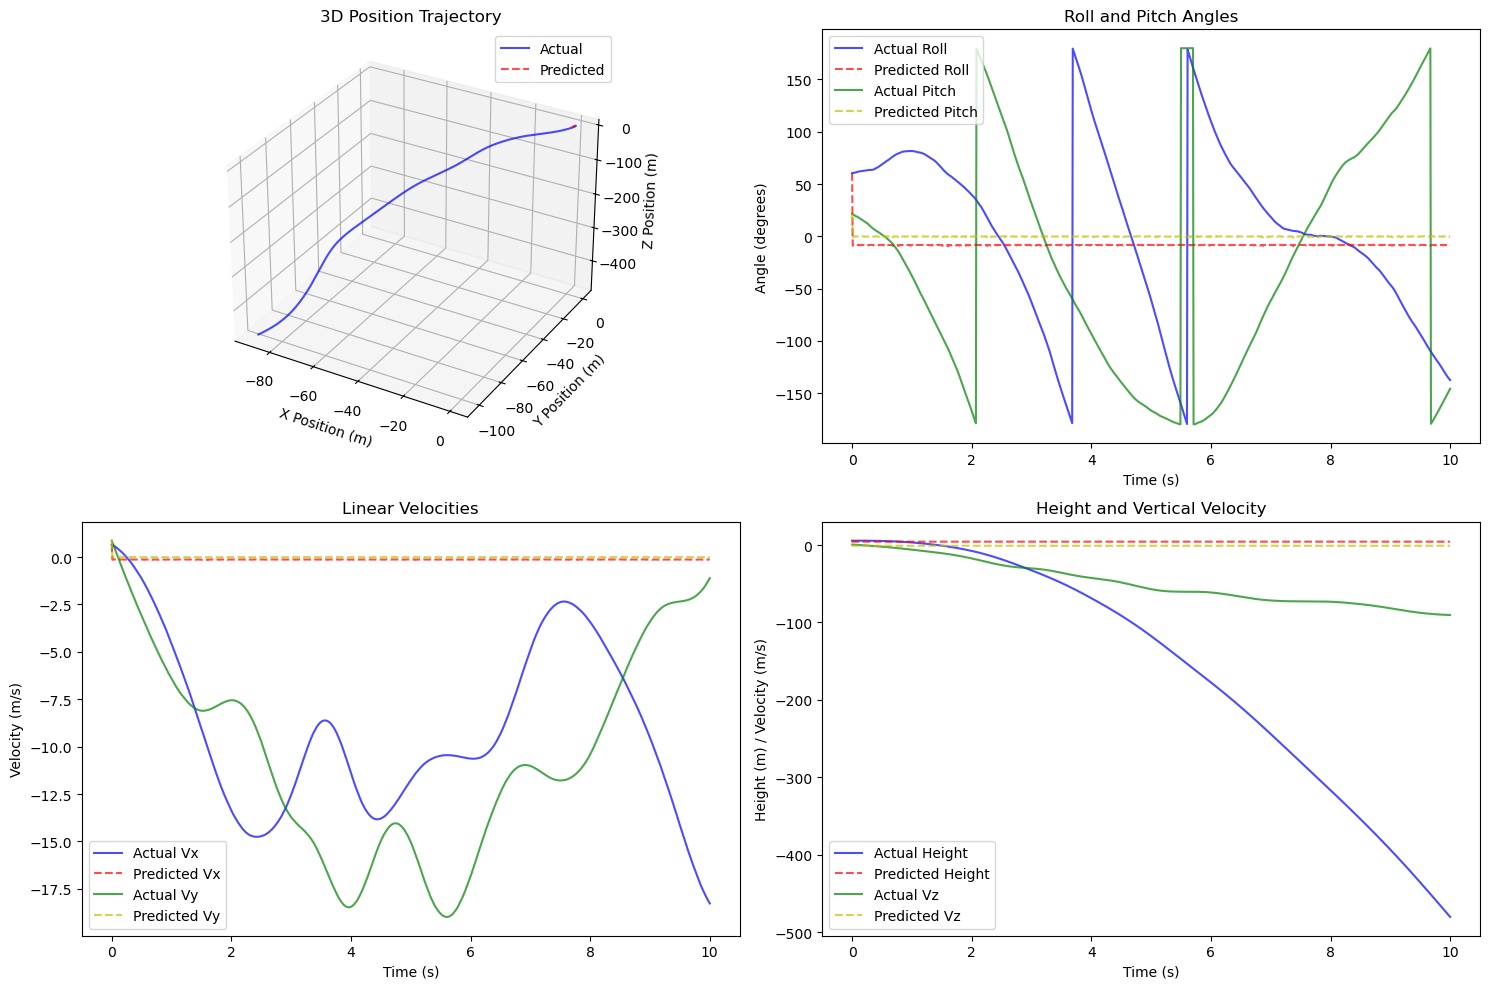

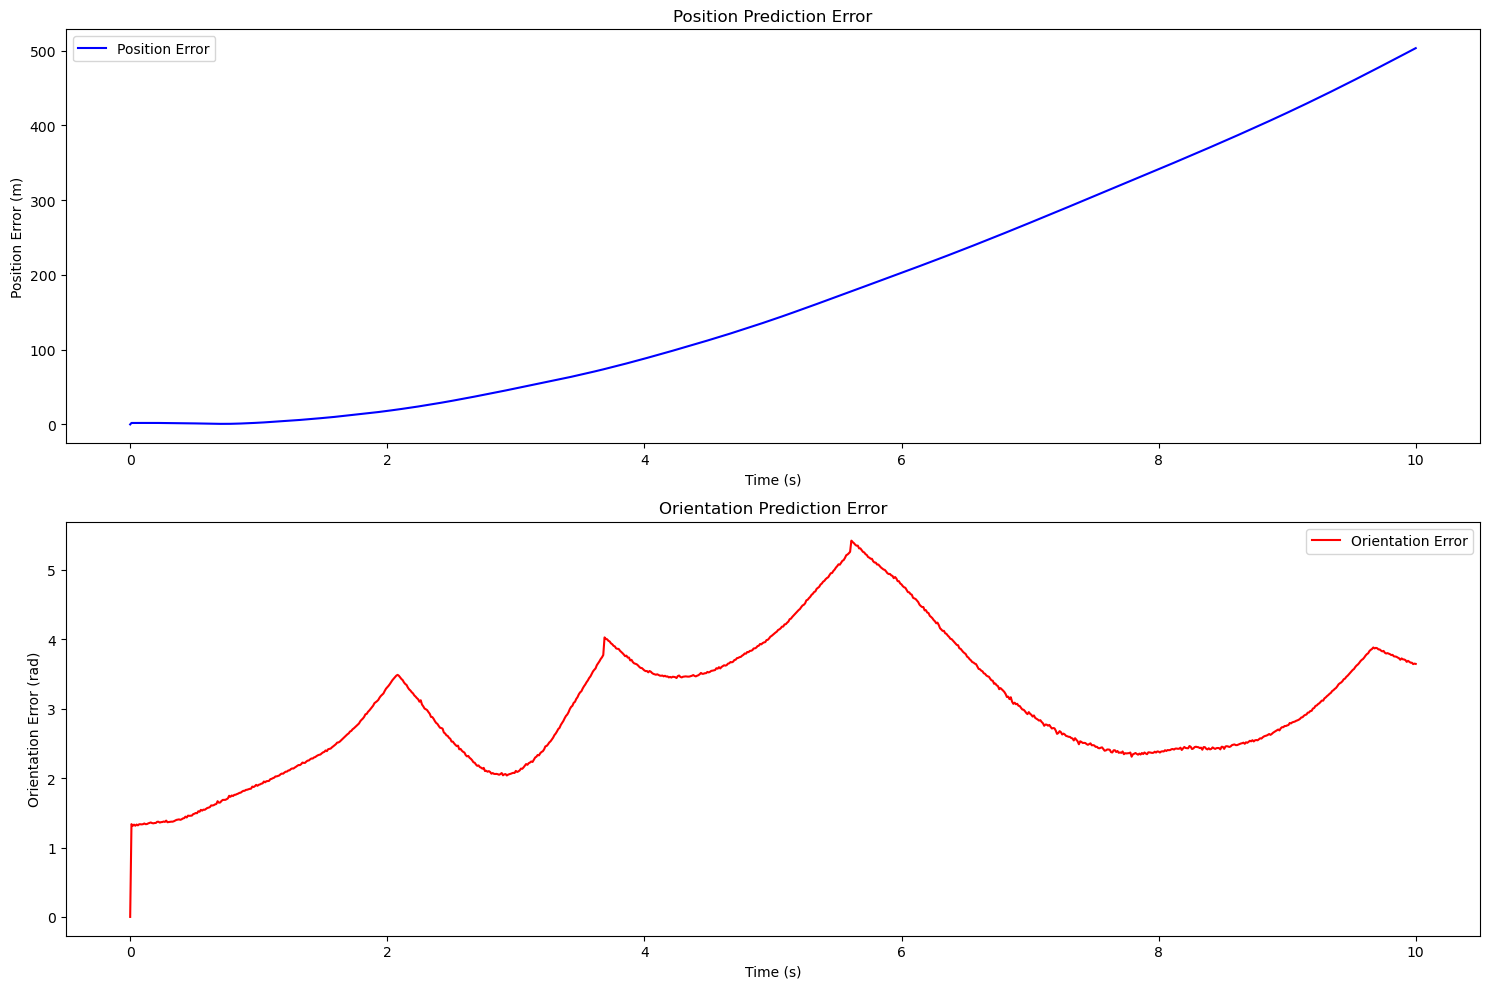